# Exercice 2

# Introduction

In [81]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from keras import layers, losses
from tensorflow.keras import applications, layers, optimizers, losses, callbacks, Sequential, metrics

In [123]:
cars196 = tfds.load('Cars196', as_supervised=True, shuffle_files=True)

In [83]:
cars_tr=cars196['train']

In [84]:
image, label = next(iter(cars_tr))

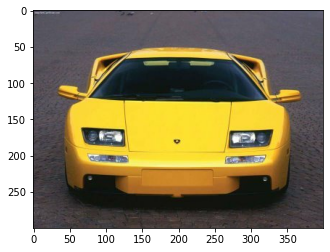

In [85]:
import matplotlib.pyplot as plt
plt.imshow(image)

# Preprocessing

## Image preprocessing

**First :** 

I looked for extrem, mean and median values of shapes on the overall images in the dataset.
Then i will be able to resize images in order to have a single input shape.

In [86]:
x=[]
y=[]
for im,lab in iter(cars_tr):
  x.append(im.shape[0])
  y.append(im.shape[1])

print(max(x),min(x),np.mean(x))
print(max(y),min(y),np.mean(y))
print(np.median(x), np.median(y))

3744 57 482.74840373280944
5616 78 699.8166748526522
424.0 637.0


So we saw that all images in the dataset have not the same shapes.
In order to work with unique shapes, i decided to combined resize and rescale functions.

For the resize shapes i first think that using the shape of the median was the best tradeoff. But when i looked for information on it expert talk about 64x64 or 128x128. So i finally chose to take 128x128 because it was closer to the median than 64x64.

And then, i cast values in the tensor to float and scales values by dividing by 255.

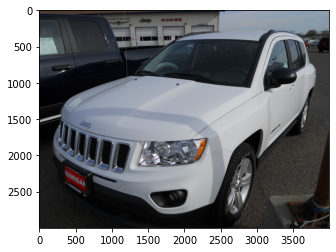

In [87]:
for im,lab in iter(cars_tr):
  if im.shape[0]>=3000:
    a=im
    plt.imshow(im)
    break

(128, 128, 3)


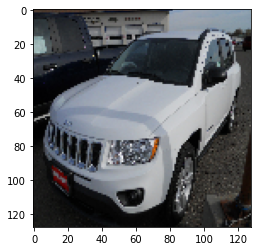

In [88]:
a=tf.image.resize(a,[128,128])
a = tf.cast(a, tf.float32)/255.0
print(a.shape)
plt.imshow(a)

In [89]:
def preprocess(image, label):
  image=tf.image.resize(image,[128,128])
  image= tf.cast(image, tf.float32)/255.0
  return image, label

**Secondly :**

I look to apply different function for data augmentation.


First idea was to play with parameters of the tensor to create data augmentation. For this i use many functions in tf.image.random_'something' that allows, by playing on different parameters, to change the input datas in the batch. So i apply random_crop, random_fip_left_right, random_brightness and random_saturation.

But the issue that comes to mind first, was the idea that color was not correlated with the model of the car and keeping the color will add a bias and more computation time. So i first think to replace the 3 channels to 1 (grayscale images). But with research on the net i find that in tf.image existed a function that handle that problem by randomly change the color (random_hue). By this function, i force the code to don't take color as key factor to classify cars.



In [90]:
def aug(image, label):
  image = tf.image.random_crop(image, size=[128, 128,3])
  image=tf.image.random_flip_left_right(image)
  image = tf.image.random_brightness(image, 0.1)
  image = tf.image.random_hue(image, 0.25)
  image = tf.image.random_saturation(image, 0, 2)
  return image, label

Then i look for a way to improve image quality by removing blur on it. I saw in an other course different ways to delete blur using convolution and filters (Gaussian filter). But i finally did not apply it because aliasing effect may not occur on our images (our dataset stores car images so it will certainly not contain any images that might have moiré pattern).

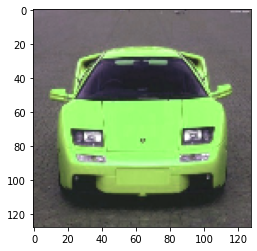

In [91]:
for image,label in iter(cars_tr):
  image,label=preprocess(image,label)
  image,label=aug(image,label)
  plt.imshow(image)
  break

## Data set construction

In [92]:
cars_train=cars196['train']
cars_test=cars196['test']

In [93]:
cars_train=cars_train.map(preprocess).map(aug).shuffle(800).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
cars_test=cars_test.map(preprocess).map(aug).shuffle(800).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

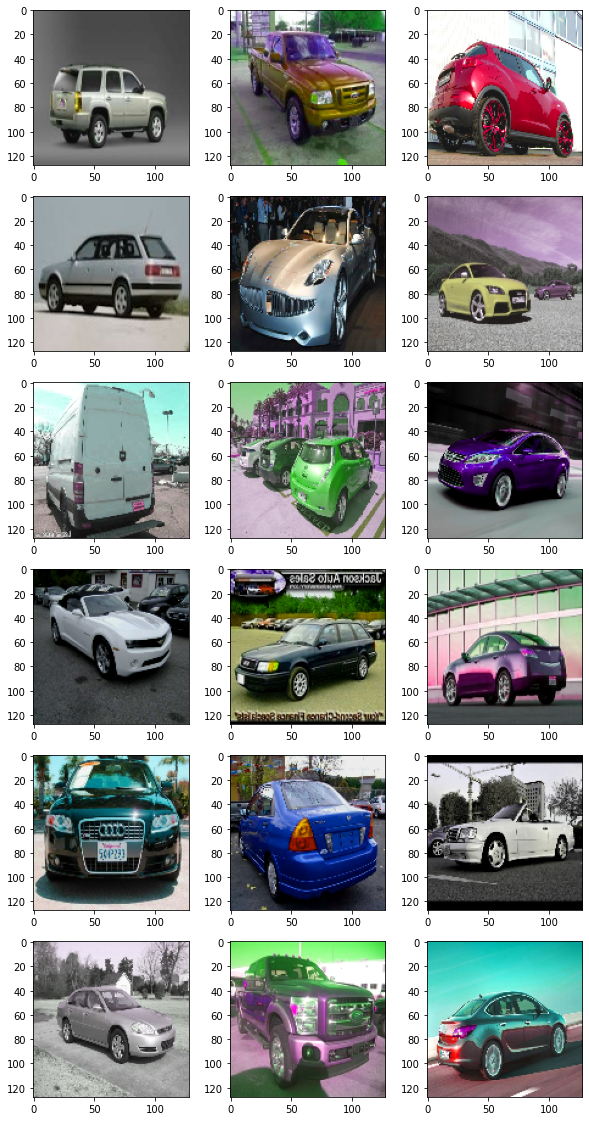

In [94]:
plt.figure(figsize=(10,20))
for i,(image_batch,label) in enumerate(cars_train.take(18)):
    ax=plt.subplot(6, 3, i+1)
    plt.imshow(image_batch[0])

# Model construction

# First model

In [95]:
inp = tf.keras.layers.Input(shape=(128,128,3))

In [96]:
def block(x,filters,kernel_size):
  x=tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size,strides=2,padding='same',
                           kernel_regularizer=tf.keras.regularizers.l2(1e-3),
                          kernel_initializer=tf.keras.initializers.glorot_normal)(x)
  x=tf.keras.layers.BatchNormalization()(x)
  x=tf.keras.layers.ReLU()(x)
  return x

def block_interpretability(x,filters,kernel_size):
  x=tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size,strides=2,padding='same',
                           kernel_regularizer=tf.keras.regularizers.l2(1e-3),
                          kernel_initializer=tf.keras.initializers.glorot_normal)(x)
  x=tf.keras.layers.BatchNormalization()(x)
  x=tf.keras.layers.ReLU()(x)
  return x

In [97]:
def function_model():
  input=tf.keras.layers.Input(shape=(128,128,3))
  x=block(input,64,3)
  x=block(x,128,3)
  x=block(x,256,3)
  x=block(x,512,3)
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dropout(0.5)(x)
  x = layers.Dense(196, activation='softmax')(x)  #use softmax because of the multiclass classification problem
  return tf.keras.Model(inputs=input,outputs=x)

In [98]:
first_model=function_model()
first_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
batch_normalization_20 (Batc (None, 64, 64, 64)        256       
_________________________________________________________________
re_lu (ReLU)                 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
batch_normalization_21 (Batc (None, 32, 32, 128)       512       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 32, 32, 128)       0     

In [99]:
first_model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=optimizers.Adam(),
              metrics=[metrics.SparseCategoricalAccuracy()])

In [100]:
callback = [
             callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=5, restore_best_weights=True),
             callbacks.TerminateOnNaN()
            ]

In [101]:
first_model.fit(cars_train, epochs=40, validation_data=cars_test,callbacks=callback)

Epoch 1/40
255/255 [==============================] - 53s 194ms/step - loss: 6.1205 - sparse_categorical_accuracy: 0.0061 - val_loss: 5.6152 - val_sparse_categorical_accuracy: 0.0058
Epoch 2/40
255/255 [==============================] - 45s 168ms/step - loss: 5.6427 - sparse_categorical_accuracy: 0.0078 - val_loss: 5.4573 - val_sparse_categorical_accuracy: 0.0066
Epoch 3/40
255/255 [==============================] - 45s 168ms/step - loss: 5.4696 - sparse_categorical_accuracy: 0.0066 - val_loss: 5.5749 - val_sparse_categorical_accuracy: 0.0066
Epoch 4/40
255/255 [==============================] - 45s 168ms/step - loss: 5.4295 - sparse_categorical_accuracy: 0.0083 - val_loss: 5.3971 - val_sparse_categorical_accuracy: 0.0081
Epoch 5/40
255/255 [==============================] - 45s 168ms/step - loss: 5.3795 - sparse_categorical_accuracy: 0.0089 - val_loss: 7.0674 - val_sparse_categorical_accuracy: 0.0060
Epoch 6/40
255/255 [==============================] - 45s 168ms/step - loss: 5.3803 -

Here i concluded that the problem was very complicated and cound not be solve with a naive implementation of convolution layers.
We see that a the train accuracy was partially rising up to 14% max. In the same time, the accuracy on the test set was around 6% maximum. This is clearly not enough even if the problem is complex (high number of classes).

Even if the accuracy was rising linearly, we see that between the last two epochs, the train accuracy remains approximately constant while the test accuracy drops suddenly. I thinks that this last epochs was the beginning of test accuracy decreasing, and therefore highligths the beginning of overfitting.

So i chose to implement an other model based on fine tunning model.

# Second model


Here i choose to do a fine tune implementation based in Xception model.

In [102]:
cars_train=cars196['train']
cars_test=cars196['test']

In [103]:
cars_train=cars_train.map(preprocess).map(aug).shuffle(800).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
cars_test=cars_test.map(preprocess).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [104]:
Xception=tf.keras.applications.Xception(weights="imagenet", input_shape=(128, 128, 3), include_top=False)
Xception.trainable=True

83689472/83683744 [==============================] - 1s 0us/step


In [105]:
model = Sequential(layers=[
                           layers.Input((128,128,3)),
                           layers.Lambda(tf.keras.applications.xception.preprocess_input),
                           Xception,
                           layers.GlobalAveragePooling2D(),
                           layers.Dropout(0.5),
                           layers.Flatten(),
                           layers.Dense(196,activation='softmax')
])

In [106]:
model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=optimizers.Adam(1e-5),
              metrics=[metrics.SparseCategoricalAccuracy()])
callback = [
             callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=5, restore_best_weights=True),
             callbacks.TerminateOnNaN()
            ]

In [107]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 128, 128, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 4, 4, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 196)               401604    
Total params: 21,263,084
Trainable params: 21,208,556
Non-trainable params: 54,528
_______________________________________

In [108]:
model.fit(cars_train, epochs=50, validation_data=cars_test, callbacks=callback)

Epoch 1/50
255/255 [==============================] - 75s 268ms/step - loss: 5.3486 - sparse_categorical_accuracy: 0.0041 - val_loss: 5.2781 - val_sparse_categorical_accuracy: 0.0077
Epoch 2/50
255/255 [==============================] - 71s 269ms/step - loss: 5.2746 - sparse_categorical_accuracy: 0.0055 - val_loss: 5.2777 - val_sparse_categorical_accuracy: 0.0057
Epoch 3/50
255/255 [==============================] - 71s 271ms/step - loss: 5.2699 - sparse_categorical_accuracy: 0.0082 - val_loss: 5.2715 - val_sparse_categorical_accuracy: 0.0073
Epoch 4/50
255/255 [==============================] - 71s 271ms/step - loss: 5.2546 - sparse_categorical_accuracy: 0.0089 - val_loss: 5.2642 - val_sparse_categorical_accuracy: 0.0071
Epoch 5/50
255/255 [==============================] - 72s 273ms/step - loss: 5.2289 - sparse_categorical_accuracy: 0.0120 - val_loss: 5.2339 - val_sparse_categorical_accuracy: 0.0107
Epoch 6/50
255/255 [==============================] - 72s 276ms/step - loss: 5.1649 -

This fine tuning method has, as excepted, clearly better results than my first model and without overfitting.

The final train accuracy approches 83% while test accuracy is closed to 40%.
In my opinion, overfitting was not reach, and with more epochs we could have improve the model to a better accuracy (here the problem was the computational time).

In [109]:
model = tf.keras.models.load_model('model.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 128, 128, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 4, 4, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 196)               401604    
Total params: 21,263,084
Trainable params: 21,208,556
Non-trainable params: 54,528
_____________________________________

 # Exercice 3

I honestly first try to implement 'attacking model' algorithme but CleverHands looks too complicated for something i did not know well, Foolbox implementation model returned me a large number of errors during the corresponding library importation, aix360 required 'attacks' module that did not exist according to my 'aix360' version (while i have pip install the last version).

Then i try 'interpretability'. The AIX360 module required a version of tensorFlow where 'import tensorflow_datasets' returned an error (so i was no longer able to download my datas) and 'tf-explain' tutorials where not very helpfull.

In this part i try to implement LIME interpretability on my model using the  GitHub.
I did not know anything about this library and how to use it, so a part of my code comes from tutorials examples i find on GitHub and thanks to links you send us.

In [110]:
from keras.applications.imagenet_utils import decode_predictions

In [111]:
model = tf.keras.models.load_model('model.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 128, 128, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 4, 4, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 196)               401604    
Total params: 21,263,084
Trainable params: 21,208,556
Non-trainable params: 54,528
_____________________________________

The interpretability of my second model returned me errors and i was not able to face it. So i try interpretability on the Xception model that is a major part of my second_model (i fine tune from Xception model).

In [126]:
cars_train=cars196['train']
cars_test=cars196['test']

In [127]:
Xception=tf.keras.applications.Xception() # loading the Xception model i used in my second_model

In [128]:
def preprocc(ten):
  out = []
  for im, label in iter(ten):
    im=tf.image.resize(im,[299,299]) # i dont know why but the 'tf.keras.applications.xception.preprocess_input' line 3 lienes after does not the correct reshapingso i added myself
    x=im.numpy()
    x = np.expand_dims(x, axis=0)
    x = tf.keras.applications.xception.preprocess_input(x)
    out.append(x)
    break
  return np.vstack(out)

In [129]:
t=preprocc(cars_test)
t.shape

(1, 299, 299, 3)

('n03594945', 'jeep', 0.76211673)
('n03930630', 'pickup', 0.07706466)
('n04252225', 'snowplow', 0.015326021)
('n04461696', 'tow_truck', 0.008893162)
('n03345487', 'fire_engine', 0.007848382)


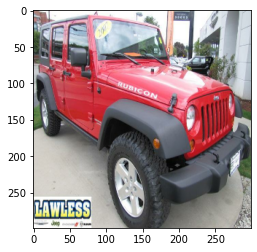

In [130]:
plt.imshow(t[0] / 2 + 0.5)
preds = Xception_model.predict(t)
for x in decode_predictions(preds)[0]:
    print(x)

In [118]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [131]:
explainer = lime_image.LimeImageExplainer() #creating the explainer object
explanation = explainer.explain_instance(t[0].astype('double'), Xception_model.predict, top_labels=5, hide_color=0, num_samples=1000) # creating explanation based on my datas according to Xception model

Here i used segmentation to mark boudnaries the model uses for his classification.

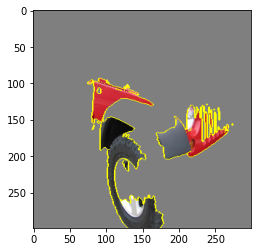

In [132]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

We saw on this image that the algorithm classified well because it given as first prediction 'jeep'.
The more relevant pixels it used for classification has been choosen wisely : we can see the radiators bars of the engine (in the front of the car) that are unique to jeep cars. It also took in account the mud grade and thick tyre.

I also try a method that uses pros and cons (green is features he choose to base on for the computation and red are cons).

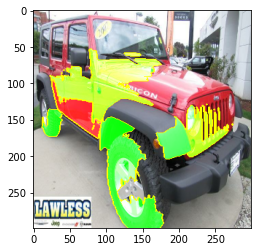

In [133]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Here we see that wheels and tyres where the pros for the classification in jeep class (as we already said it focused on an appropriate features because thick tyres and wheels are one of the features of 4x4 and jeep). The reason why he chose 'jeep' class in first is (in my opinion) thanks to the radiator bars (in yellow here).

I did not think that i was relevant to apply the same process for the second class because the accuracy was drasticly less important (76% for jeep against 7.7% for pickup.

But even if the accuracy was not high, i just found interesting to study area of the images it extracted to return 'pickup'.

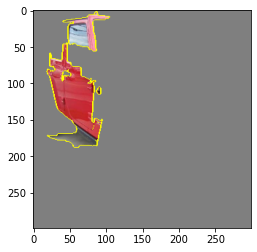

In [135]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[1], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Here we understood why the confidence was only 7.7%. Except the step to get in the car (that is often present in pickup or big car in general) it based it computation on the door and the window; features that are not very relevant to distinguish a class of cars against an other (amon 196 possibilities).